In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [3]:
def halton_sequence(n, b):
    sequence = np.zeros(n)
    for i in range(1, n + 1):
        h = 0
        f = 1 / b
        i_copy = i
        while i_copy > 0:
            h += f * (i_copy % b)
            i_copy = i_copy // b
            f /= b
        sequence[i-1]=h
    return sequence

In [4]:
def box_muller_normal(n):
    u1 = np.random.uniform(size = (n//2))
    u2 = np.random.uniform(size = (n//2))
    r = np.sqrt(-2 * np.log(u1)) 
    phi = 2 * np.pi * u2
    z1 = r * np.cos(phi)
    z2 = r * np.sin(phi)
    normal_variables = np.concatenate((z1,z2))
    return normal_variables

In [5]:
def box_muller_normal_halton(n, base1, base2):
    u1 = halton_sequence(n//2, base1)
    u2 = halton_sequence(n//2, base2)
    r = np.sqrt(-2 * np.log(u1)) 
    phi = 2 * np.pi * u2
    z1 = r * np.cos(phi)
    z2 = r * np.sin(phi)
    normal_variables = np.concatenate((z1,z2))
    return normal_variables

In [6]:
def black_scholes_call(S0, K, r, sigma, T):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    return call_price

In [7]:
def CallMC(S0, r, sigma, T, K, M, conf):
    dt = T

    z1 = box_muller_normal(M)
    variable1 = (r - 0.5 * sigma**2) * dt
    variable2 = sigma * np.sqrt(dt) * z1
    ST1 = S0 * np.exp(variable1 + variable2)
    ST2 = S0 * np.exp(variable1 - variable2)
    ST = np.concatenate((ST1,ST2))
    payoff = np.maximum(ST-K,0)
    price = np.mean(payoff)
    z2 = box_muller_normal_halton(M, 2, 3)
    variable3 = sigma * np.sqrt(dt) * z2
    ST3 = S0 * np.exp(variable1 + variable3)
    payoff3 = np.maximum(ST3-K,0)
    mean_payoffs_QMC = np.mean(payoff3)


    call_price_MC = np.exp(-r * T) * (price)
    call_price_QMC = np.exp(-r * T) * (mean_payoffs_QMC)
    if (conf == 1):
        return call_price_MC, call_price_QMC
    else:
        a_M = call_price_MC 
        b_M = np.sqrt(np.sum((np.exp(-r * T)*(np.maximum(ST1-K,0)+np.maximum(ST2-K,0))/2-a_M)**2)/(M-1))
        confidence_interval_down = a_M - 1.96*b_M/np.sqrt(M)
        confidence_interval_up = a_M + 1.96*b_M/np.sqrt(M)
        return call_price_MC, call_price_QMC, confidence_interval_down, confidence_interval_up

In [8]:
def input_data(filename):
    with open(filename, 'r') as file:
        # read file contents
        lines = file.readlines()
    # initializing variables
    S0, r, sigma, T, K, M = None, None, None, None, None, None
    # reading lines in file
    for line in lines:
        # split line for two parts before and after "="
        parts = line.split('=')
        # check if line was split into to parts
        if len(parts) == 2:
            # delete spaces for the end
            variable_name = parts[0].strip()
            value = parts[1].strip()
            # assing values to variables
            if variable_name == 'S0':
                S0 = float(value)
            elif variable_name == 'r':
                r = float(value)
            elif variable_name == 'sigma':
                sigma = float(value)
            elif variable_name == 'T':
                T = float(value)
            elif variable_name == 'K':
                K = float(value)
            elif variable_name == 'M':
                M = int(value)
    call_price_MC, call_price_QMC, confidence_interval_down, confidence_interval_up = CallMC(S0, r, sigma, T, K, M, 0)
    price_reference = black_scholes_call(S0, K, r, sigma, T)
    relative_error_MC = np.abs(call_price_MC-price_reference)/np.abs(price_reference)
    relative_error_QMC = np.abs(call_price_QMC-price_reference)/np.abs(price_reference)
    
    print("European option")
    print("Option Price (MC):", call_price_MC)
    print("Option Price (QMC):", call_price_QMC)
    print("Confidence interval: (", confidence_interval_down,",",confidence_interval_up,")")
    print("Relative error (MC):", relative_error_MC)
    print("Relative error (QMC):", relative_error_QMC)

In [9]:
input_data('cp2_data.txt')

European option
Option Price (MC): 4.452787361253202
Option Price (QMC): 4.457815931412742
Confidence interval: ( 4.374531471017029 , 4.5310432514893755 )
Relative error (MC): 0.0006972549707206004
Relative error (QMC): 0.00043126601092936784


In [10]:
def download_data(filename):
    with open(filename, 'r') as file:
        # read file contents
        lines = file.readlines()
    # initializing variables
    S0, r, sigma, T, K, M = None, None, None, None, None, None
    # reading lines in file
    for line in lines:
        # split line for two parts before and after "="
        parts = line.split('=')
        # check if line was split into to parts
        if len(parts) == 2:
            # delete spaces for the end
            variable_name = parts[0].strip()
            value = parts[1].strip()
            # assing values to variables
            if variable_name == 'S0':
                S0 = float(value)
            elif variable_name == 'r':
                r = float(value)
            elif variable_name == 'sigma':
                sigma = float(value)
            elif variable_name == 'T':
                T = float(value)
            elif variable_name == 'K':
                K = float(value)
            elif variable_name == 'M':
                M = int(value)
    return S0, r, sigma, T, K, M

S0, r, sigma, T, K, M = download_data('cp2_data.txt')

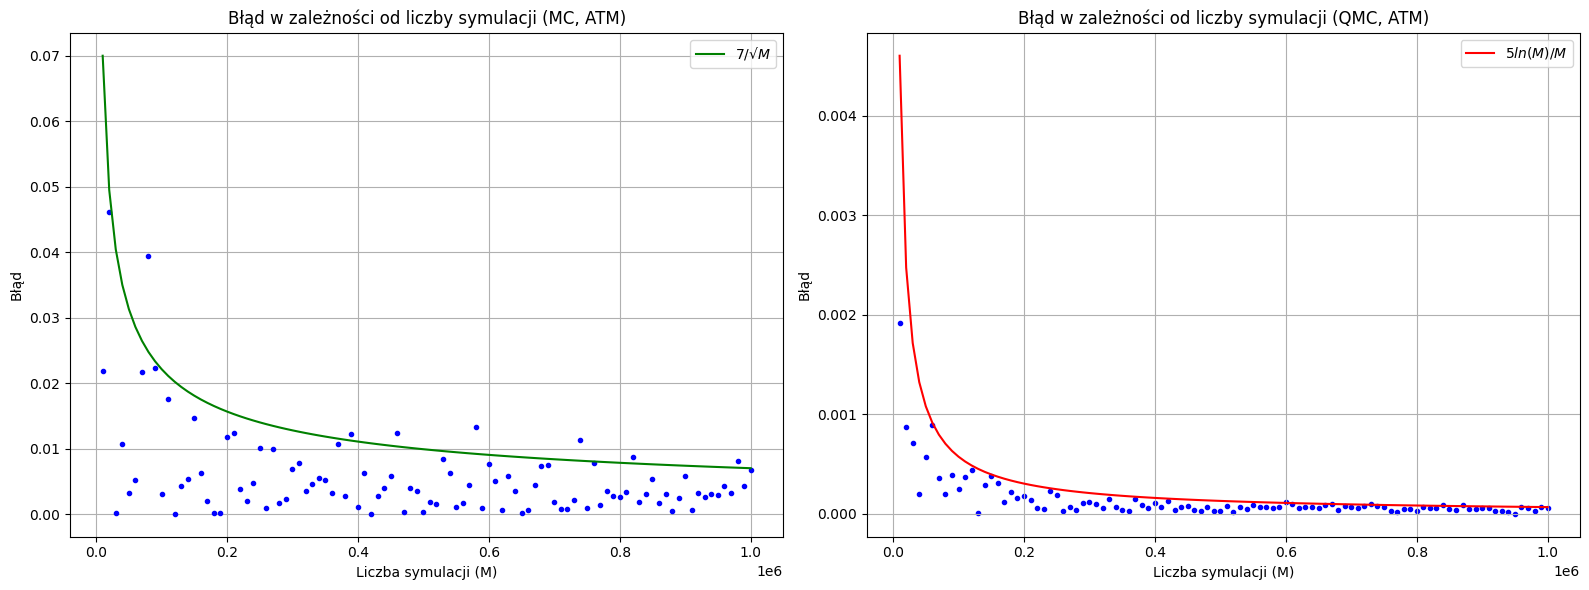

In [11]:
M_values = np.arange(10000, 1000001, 10000)
K=S0
# Obliczanie cen opcji dla różnych wartości M
m=len(M_values)
error_QMC = np.zeros(m)
error_MC = np.zeros(m)
call_price_MC = np.zeros(m)
call_price_QMC = np.zeros(m)                    
call_price_reference = black_scholes_call(S0, K, r, sigma, T)
i=0
for M in M_values:
    call_price_MC[i], call_price_QMC[i] = CallMC(S0, r, sigma, T, K, M, 1)
    i=i+1

error_QMC = np.abs(call_price_QMC-call_price_reference)
error_MC= np.abs(call_price_MC-call_price_reference)
    # Rysowanie wykresu wyników
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(M_values, error_MC, color='blue', marker='.', linestyle='None')
plt.plot(M_values, 7/np.sqrt(M_values), color='green',label='$7/√M$')
plt.title('Błąd w zależności od liczby symulacji (MC, ATM)')
plt.xlabel('Liczba symulacji (M)')
plt.ylabel('Błąd')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(M_values, error_QMC, color='blue',marker='.', linestyle='None')
plt.plot(M_values, 5*np.log(M_values)/M_values, color='red', label='$5ln(M)/M$')
plt.title('Błąd w zależności od liczby symulacji (QMC, ATM)')
plt.xlabel('Liczba symulacji (M)')
plt.ylabel('Błąd')
plt.legend()
plt.grid(True)



plt.tight_layout()
plt.show()

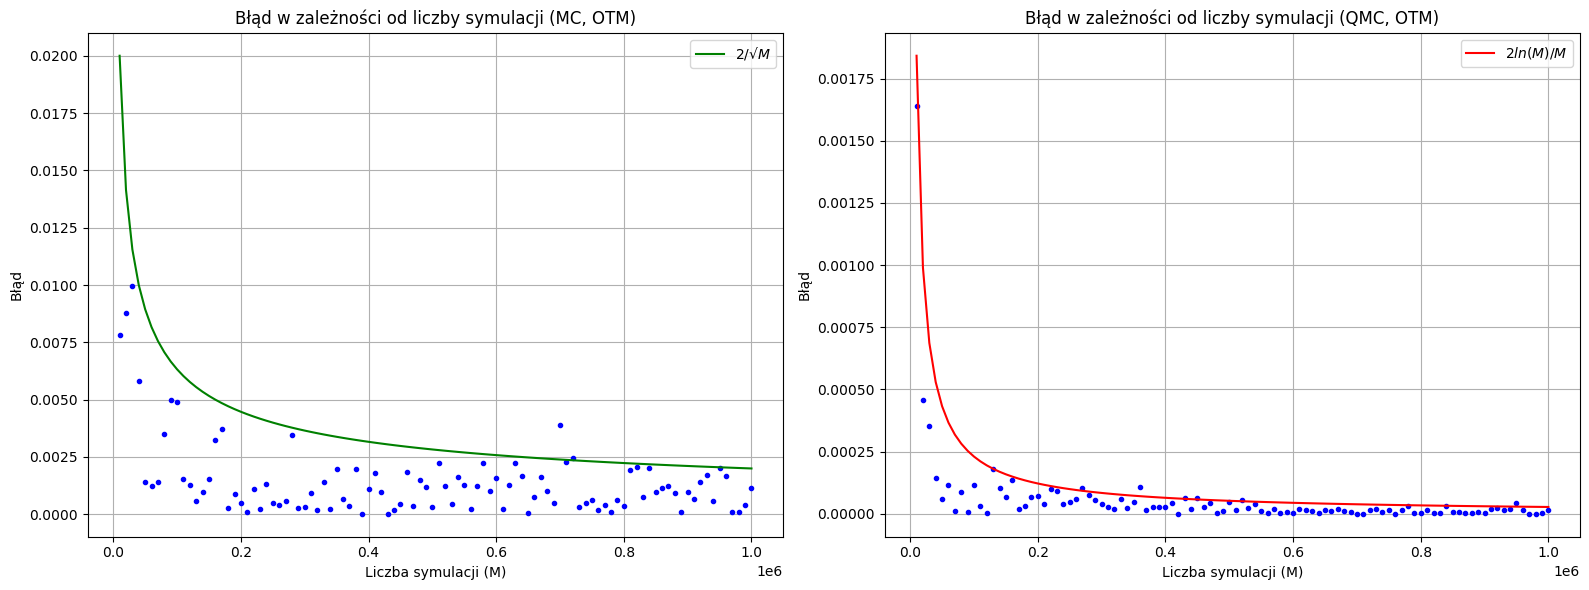

In [12]:
M_values = np.arange(10000, 1000001, 10000)
K=1.5*S0
# Obliczanie cen opcji dla różnych wartości M
m=len(M_values)
error_QMC = np.zeros(m)
error_MC = np.zeros(m)
call_price_MC = np.zeros(m)
call_price_QMC = np.zeros(m)                    
call_price_reference = black_scholes_call(S0, K, r, sigma, T)
i=0
for M in M_values:
    call_price_MC[i], call_price_QMC[i] = CallMC(S0, r, sigma, T, K, M, 1)
    i=i+1

error_QMC = np.abs(call_price_QMC-call_price_reference)
error_MC= np.abs(call_price_MC-call_price_reference)
# Rysowanie wykresu wyników
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(M_values, error_MC, color='blue', marker='.', linestyle='None')
plt.plot(M_values, 2/np.sqrt(M_values), color='green', label='$2/√M$')
plt.title('Błąd w zależności od liczby symulacji (MC, OTM)')
plt.xlabel('Liczba symulacji (M)')
plt.ylabel('Błąd')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(M_values, error_QMC, color='blue', marker='.', linestyle='None')
plt.plot(M_values, 2*np.log(M_values)/M_values, color='red', label='$2ln(M)/M$')
plt.title('Błąd w zależności od liczby symulacji (QMC, OTM)')
plt.xlabel('Liczba symulacji (M)')
plt.ylabel('Błąd')
plt.legend()
plt.grid(True)



plt.tight_layout()
plt.show()

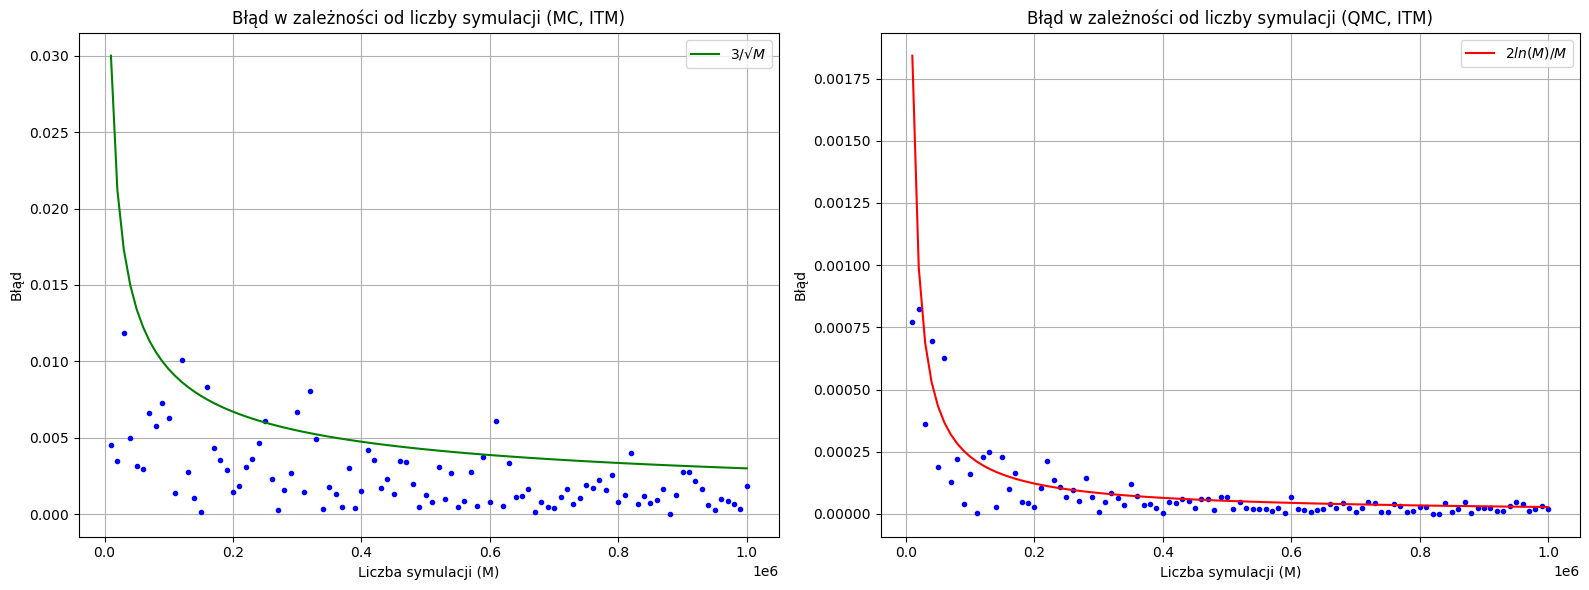

In [13]:
M_values = np.arange(10000, 1000001, 10000)
K=0.5*S0
# Obliczanie cen opcji dla różnych wartości M
m=len(M_values)
error_QMC = np.zeros(m)
error_MC = np.zeros(m)
call_price_MC = np.zeros(m)
call_price_QMC = np.zeros(m)                    
call_price_reference = black_scholes_call(S0, K, r, sigma, T)
i=0
for M in M_values:
    call_price_MC[i], call_price_QMC[i] = CallMC(S0, r, sigma, T, K, M, 1)
    i=i+1

error_QMC = np.abs(call_price_QMC-call_price_reference)
error_MC= np.abs(call_price_MC-call_price_reference)
    # Rysowanie wykresu wyników
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(M_values, error_MC, color='blue', marker='.', linestyle='None')
plt.plot(M_values, 3/np.sqrt(M_values), color='green', label='$3/√M$')
plt.title('Błąd w zależności od liczby symulacji (MC, ITM)')
plt.xlabel('Liczba symulacji (M)')
plt.ylabel('Błąd')
plt.legend()
plt.grid(True)    

plt.subplot(1, 2, 2)
plt.plot(M_values, error_QMC, color='blue', marker='.', linestyle='None')
plt.plot(M_values, 2*np.log(M_values)/M_values, color='red', label='$2ln(M)/M$')
plt.title('Błąd w zależności od liczby symulacji (QMC, ITM)')
plt.xlabel('Liczba symulacji (M)')
plt.ylabel('Błąd')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()